# MNIST-Neural Network-Two Hidden Layers with Variable Optimziers

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.functions import *
from common.layers import *
from common.util import *
from common.optimizers import *

## Multilayer Neural Network Model

In [2]:
import sys, os
from collections import OrderedDict
from scipy import stats
from pandas import DataFrame

class TwoLayerNet:
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_layer1_size)
        self.params['b1'] = np.zeros(hidden_layer1_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_layer1_size, hidden_layer2_size)
        self.params['b2'] = np.zeros(hidden_layer2_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_layer2_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = ReLU()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithCrossEntropyLoss()
            
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        din = 1
        din = self.lastLayer.backward(din)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
    
    def learning(self, learning_rate, x_batch, t_batch, optimizer):
        grads = self.backpropagation_gradient(x_batch, t_batch)
        optimizer.update(self.params, grads)

## Learning and Validation

In [3]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['Nesterov'] = Nesterov()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSprop'] = RMSprop()
optimizers['Adam'] = Adam()

num_epochs = 50
train_size = img_train.shape[0]
batch_size = 1000
learning_rate = 0.1

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}
max_test_accuracy_epoch = {}
max_test_accuracy_value = {}

for key in optimizers.keys():
    networks[key] = TwoLayerNet(input_size=784, hidden_layer1_size=128, hidden_layer2_size=128, output_size=10)
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []
    max_test_accuracy_epoch[key] = 0
    max_test_accuracy_value[key] = 0.0

num_batch = math.ceil(train_size / batch_size)
epoch_list = []

for i in range(num_epochs):
    epoch_list.append(i)
    for key in optimizers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[key].learning(learning_rate, x_batch, t_batch, optimizers[key])

        train_loss = networks[key].loss(x_batch, t_batch)
        train_errors[key].append(train_loss)

        validation_loss = networks[key].loss(img_validation, label_validation)
        validation_errors[key].append(validation_loss)    

        test_accuracy = networks[key].accuracy(img_test, label_test)
        test_accuracy_values[key].append(test_accuracy)
        if test_accuracy > max_test_accuracy_value[key]:
            max_test_accuracy_epoch[key] = i            
            max_test_accuracy_value[key] = test_accuracy
        print("{0:8s}-Epoch:{1:3d}, Train Err.:{2:7.5f}, Validation Err.:{3:7.5f}, Test Accuracy:{4:7.5f}, Max Test Accuracy:{5:7.5f}".format(
            key,
            i,
            train_loss,
            validation_loss,
            test_accuracy,
            max_test_accuracy_value[key]
        ))
    print()

SGD     -Epoch:  0, Train Err.:2.30247, Validation Err.:2.30244, Test Accuracy:0.11350, Max Test Accuracy:0.11350
Momentum-Epoch:  0, Train Err.:2.30181, Validation Err.:2.30151, Test Accuracy:0.11350, Max Test Accuracy:0.11350
Nesterov-Epoch:  0, Train Err.:2.30159, Validation Err.:2.30133, Test Accuracy:0.11350, Max Test Accuracy:0.11350
AdaGrad -Epoch:  0, Train Err.:0.42933, Validation Err.:0.37621, Test Accuracy:0.87570, Max Test Accuracy:0.87570
RMSprop -Epoch:  0, Train Err.:0.31946, Validation Err.:0.29008, Test Accuracy:0.89900, Max Test Accuracy:0.89900
Adam    -Epoch:  0, Train Err.:0.59923, Validation Err.:0.53937, Test Accuracy:0.81020, Max Test Accuracy:0.81020

SGD     -Epoch:  1, Train Err.:2.30234, Validation Err.:2.30228, Test Accuracy:0.11350, Max Test Accuracy:0.11350
Momentum-Epoch:  1, Train Err.:2.30104, Validation Err.:2.30057, Test Accuracy:0.11350, Max Test Accuracy:0.11350
Nesterov-Epoch:  1, Train Err.:2.30056, Validation Err.:2.30016, Test Accuracy:0.11350,

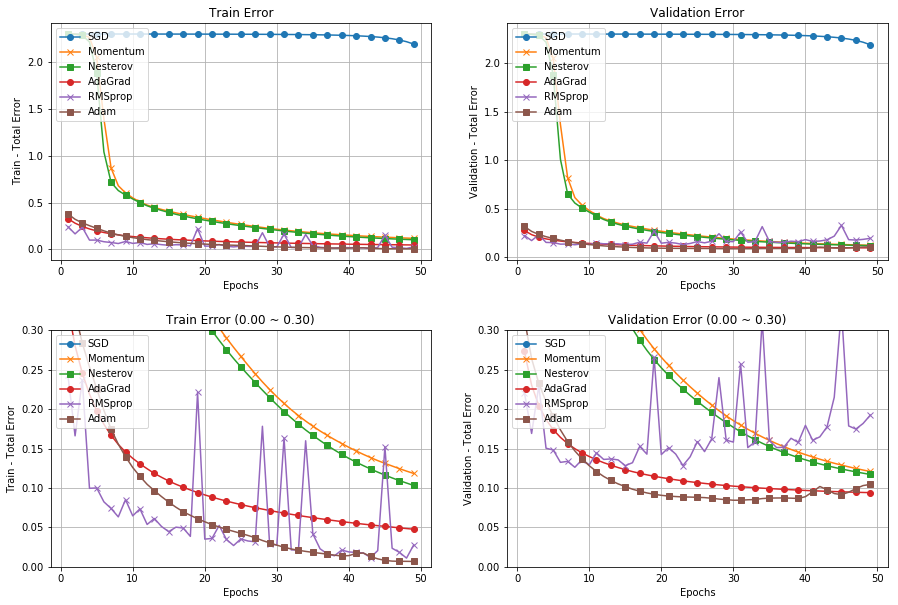

In [6]:
markers = {"SGD": "o", "Momentum": "x", "Nesterov": "s", "AdaGrad": "o", "RMSprop": "x", "Adam": "s"}

f, axarr = plt.subplots(2, 2, figsize=(15,10))
for key in optimizers.keys():
    axarr[0, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 0].set_ylabel('Train - Total Error')
axarr[0, 0].set_xlabel('Epochs')
axarr[0, 0].grid(True)
axarr[0, 0].set_title('Train Error')
axarr[0, 0].legend(loc='upper left')

for key in optimizers.keys():
    axarr[0, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0, 1].set_ylabel('Validation - Total Error')
axarr[0, 1].set_xlabel('Epochs')
axarr[0, 1].grid(True)
axarr[0, 1].set_title('Validation Error')
axarr[0, 1].legend(loc='upper left')

for key in optimizers.keys():
    axarr[1, 0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 0].set_ylabel('Train - Total Error')
axarr[1, 0].set_xlabel('Epochs')
axarr[1, 0].grid(True)
axarr[1, 0].set_ylim(0, 0.3)
axarr[1, 0].set_title('Train Error (0.00 ~ 0.30)')
axarr[1, 0].legend(loc='upper left')

for key in optimizers.keys():
    axarr[1, 1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1, 1].set_ylabel('Validation - Total Error')
axarr[1, 1].set_xlabel('Epochs')
axarr[1, 1].grid(True)
axarr[1, 1].set_ylim(0, 0.3)
axarr[1, 1].set_title('Validation Error (0.00 ~ 0.30)')
axarr[1, 1].legend(loc='upper left')

f.subplots_adjust(hspace=0.3)

plt.show()

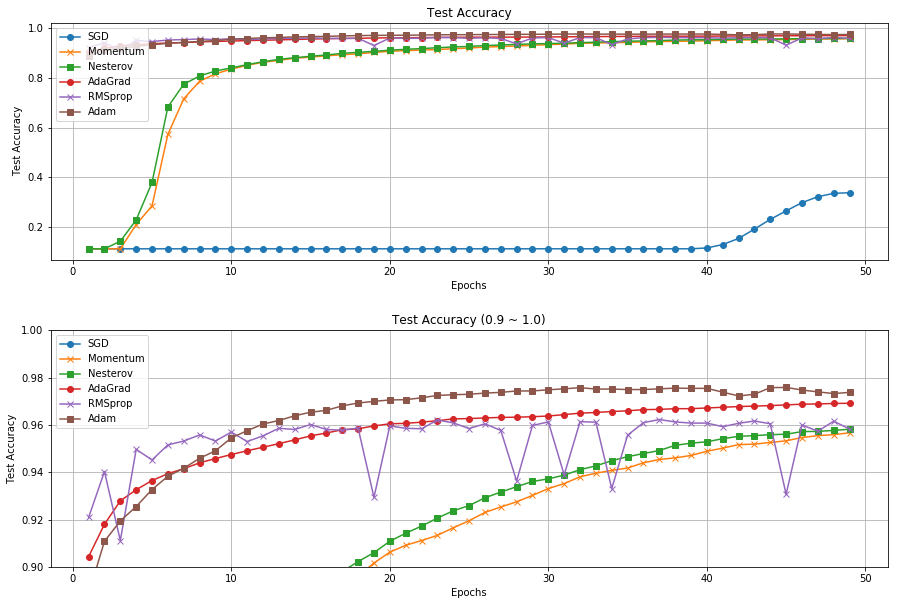

In [7]:
f, axarr = plt.subplots(2, 1, figsize=(15,10))
for key in optimizers.keys():
    axarr[0].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[0].set_ylabel('Test Accuracy')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Test Accuracy')
axarr[0].legend(loc='upper left')

for key in optimizers.keys():
    axarr[1].plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=1, label=key)
axarr[1].set_ylabel('Test Accuracy')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_ylim(0.9, 1.0)
axarr[1].set_title('Test Accuracy (0.9 ~ 1.0)')
axarr[1].legend(loc='upper left')

f.subplots_adjust(hspace=0.3)
plt.show()

In [9]:
for key in optimizers.keys():
    print("{0:26s} - Epoch:{1:3d}, Max Test Accuracy: {2:7.5f}".format(key, max_test_accuracy_epoch[key], max_test_accuracy_value[key]))

SGD                        - Epoch: 49, Max Test Accuracy: 0.33860
Momentum                   - Epoch: 49, Max Test Accuracy: 0.95670
Nesterov                   - Epoch: 49, Max Test Accuracy: 0.95820
AdaGrad                    - Epoch: 49, Max Test Accuracy: 0.96920
RMSprop                    - Epoch: 37, Max Test Accuracy: 0.96230
Adam                       - Epoch: 45, Max Test Accuracy: 0.97590
